In [34]:
import pandas as pd
import numpy as np
from typing import Optional, List, Callable, Any, Union, Dict
from itertools import product
from statistics import mean
import matplotlib.pyplot as plt
from pathlib import Path
import gzip
import os

## Import data

In [16]:
def read_ds_gzip(path: Optional[Path]=None, ds: str = "TRAIN") -> pd.DataFrame:
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with gzip.open(f'/kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

def read_ds(path: Optional[Path]=None, ds: str = "TRAIN"):
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with open(f'/kaggle/input/train-sc2-keystrokes/{ds}.CSV' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)


In [17]:
features_train = read_ds(Path(os.path.abspath('')) / "../data/TRAIN.CSV") # Replace with correct path 
# features_test = read_ds("TEST")
features_train.shape #, features_test.shape

(3052, 10539)

In [59]:
features_train

,battleneturl,played_race,0,1,2,3,4,5,6,7,...,6187,6188,6189,6190,6191,6192,6193,6194,6195,6196
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,s,s,t5,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,s,Base,s,s,Base,s,s,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,Base,s,s,Base,s,s,s,t5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,s,s,s,s,s,hotkey10,hotkey20,hotkey30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3048,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,s,s,hotkey10,s,hotkey20,s,s,hotkey12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3049,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3050,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,s,s,hotkey10,s,hotkey20,s,s,hotkey12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean dataset

## Data cleaning

##### Dropping duplicates

In [32]:
# Check for duplicate rows
duplicate_rows = features_train[features_train.duplicated()]

print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
duplicate_rows

# Drop duplicate rows
print(features_train.shape)
features_train = features_train.drop_duplicates()
print(features_train.shape)

Number of duplicate rows: 78
(3052, 10539)
(2974, 10539)


- Limit the number of actions to the threshold value using the Z-technic

Mean of non-NaN counts: 2632.7232683254874
Median of non-NaN counts: 2451.5
Minimum of non-NaN counts: 2
Maximum of non-NaN counts: 10539
Threshold for non-NaN counts outliers: 6199


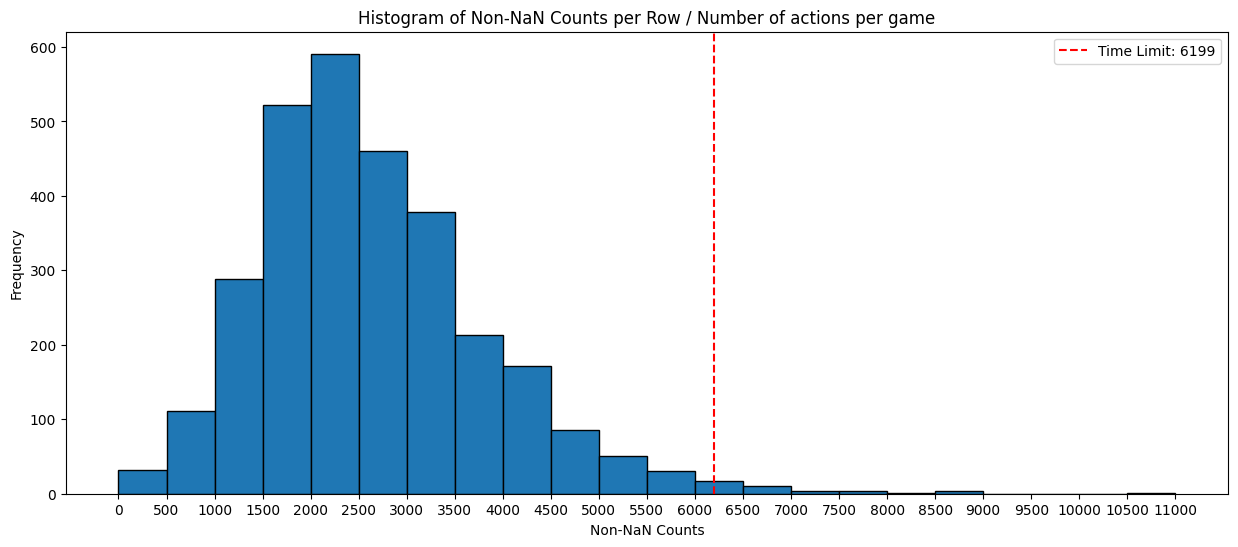

In [35]:
### Limit number of actions per game


non_nan_counts = features_train.notna().sum(axis=1)

mean_non_nan = non_nan_counts.mean()
median_non_nan = non_nan_counts.median()
min_non_nan = non_nan_counts.min()
max_non_nan = non_nan_counts.max()

print(f"Mean of non-NaN counts: {mean_non_nan}")
print(f"Median of non-NaN counts: {median_non_nan}")
print(f"Minimum of non-NaN counts: {min_non_nan}")
print(f"Maximum of non-NaN counts: {max_non_nan}")

# Compute the z-scores for non_nan_counts
z_scores_non_nan = (non_nan_counts - mean_non_nan) / non_nan_counts.std()

# Define a threshold for z-scores to identify outliers
z_threshold_non_nan = 3

non_nan_counts_threshold = non_nan_counts[abs(z_scores_non_nan) <= z_threshold_non_nan].max()

print(f"Threshold for non-NaN counts outliers: {non_nan_counts_threshold}")

# Create bins for the histogram
bins = range(0, max_non_nan + 500, 500)

# Plot the histogram
plt.figure(figsize=(15, 6))
plt.hist(non_nan_counts, bins=bins, edgecolor='black')
plt.title('Histogram of Non-NaN Counts per Row / Number of actions per game')
plt.xlabel('Non-NaN Counts')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.axvline(x=non_nan_counts_threshold, color='r', linestyle='--', label=f'Time Limit: {non_nan_counts_threshold}')
plt.legend()
plt.show()

In [36]:
print(features_train.shape)
features_train = features_train.iloc[:, :non_nan_counts_threshold]
print(features_train.shape)

(2974, 10539)
(2974, 6199)


- Remove players that haven't touched the keyboard (nan value at the first action column)

In [37]:
## Remove players that haven't touched the keyboard (nan value at the first action column)

print(features_train[0].isna().sum())
#there's 8 players that haven't touched the keyboard
#let's remove them
features_train = features_train.dropna(subset=[0])
print(features_train[0].isna().sum())
features_train.shape

7
0


(2967, 6199)

- Delete games shorter than 5 seconds

In [60]:
# Delete games <5s
def contains_t5(row):
    return 't5' in row.values

# Filter rows that don't contain "t5"
rows_without_t5 = features_train[~features_train.apply(contains_t5, axis=1)]

print(f"Number of rows without 't5': {rows_without_t5.shape[0]}")

# Drop rows that don't contain "t5"
print(features_train.shape)
features_train = features_train[features_train.apply(contains_t5, axis=1)]
print(features_train.shape)

Number of rows without 't5': 0
(2965, 6199)
(2965, 6199)


# Extract features

In [143]:
def extract_player_features(log_string):
    """
    Extract behavioral features from a StarCraft player's action log
    
    Parameters:
    log_string (str): String containing comma-separated game actions
    
    Returns:
    dict: Dictionary of extracted features
    """
    # Split the log into actions
    actions = log_string.split(',')
    
    # Basic counts
    features = {
        'total_actions': len(actions),
        'unique_actions': len(set(actions)),
    }
    
    # Action frequencies
    action_counts = Counter(actions)
    
    # APM calculation (based on timestamps 't' markers)
    time_markers = [int(a[1:]) for a in actions if a.startswith('t')]
    if time_markers:
        game_duration_minutes = max(time_markers) / 60
        features['apm'] = len(actions) / game_duration_minutes if game_duration_minutes > 0 else 0
        interval = round(max(time_markers) //15) * 5

    hotkey_actions= [a for a in actions if a.startswith('hotkey')]
    hotkey_numbers = [a[6:8] for a in hotkey_actions]
    hotkey_usage = [a for a in hotkey_actions if a.endswith('2')]
    
    features.update({
        'hotkey_frequency': len(hotkey_actions) / len(actions) if actions else 0,
        'unique_hotkeys': len(set(hotkey_numbers)),
        'most_used_hotkey': max(Counter(hotkey_numbers).items(), key=lambda x: x[1])[0] if hotkey_numbers else None
    })
    
    # Mean utilization of each hotkey
    hotkey_counts = Counter(hotkey_usage)
    total_hotkey_actions = sum(hotkey_counts.values())
    for hotkey, count in hotkey_counts.items():
        number_hotkey = hotkey[-2]
        features[f'mean_utilization_hotkey_{number_hotkey}'] = count / total_hotkey_actions if total_hotkey_actions > 0 else 0
    
    # Action bursts analysis (actions between time markers)
    burst_sizes = []
    current_burst = 0
    
    for action in actions:
        if action.startswith('t'):
            if current_burst > 0:
                burst_sizes.append(current_burst)
            current_burst = 0
        else:
            current_burst += 1
            
    features.update({
        'max_burst_size': max(burst_sizes) if burst_sizes else 0,
        'avg_burst_size': np.mean(burst_sizes) if burst_sizes else 0,
        'burst_std': np.std(burst_sizes) if burst_sizes else 0
    })
    
    # Timing patterns
    time_diffs = np.diff([int(a[1:]) for a in actions if a.startswith('t')])
    features.update({
        'avg_time_between_actions': np.mean(time_diffs) if len(time_diffs) > 0 else 0,
        'std_time_between_actions': np.std(time_diffs) if len(time_diffs) > 0 else 0
    })
    
    # New features
    features['first_action'] = actions[0] if actions else None
    first_hotkey = next((a for a in actions if a.startswith('hotkey')), None)
    features['first_hotkey_number'] = first_hotkey[6:8] if first_hotkey else None
    
    # Most used hotkeys in different parts of the game
    if time_markers:
     
            # Check for the index of tinterval and 2*tinterval
        tinterval_index = next((i for i, a in enumerate(actions) if a.startswith('t') and int(a[1:]) >= interval), None)
        t2interval_index = next((i for i, a in enumerate(actions) if a.startswith('t') and int(a[1:]) >= 2 * interval), None)
    
      

        first_part_hotkeys = [a[-2] for a in actions if a.startswith('hotkey') and a.endswith('2') and actions.index(a) < tinterval_index]
        middle_part_hotkeys = [a[-2] for a in actions if a.startswith('hotkey') and a.endswith('2') and tinterval_index <= actions.index(a) < t2interval_index]
        end_part_hotkeys = [a[-2] for a in actions if a.startswith('hotkey') and a.endswith('2') and actions.index(a) >= t2interval_index]
        
        features['most_used_hotkey_first_part'] = max(Counter(first_part_hotkeys).items(), key=lambda x: x[1])[0] if first_part_hotkeys else -1
        features['most_used_hotkey_middle_part'] = max(Counter(middle_part_hotkeys).items(), key=lambda x: x[1])[0] if middle_part_hotkeys else -1
        features['most_used_hotkey_end_part'] = max(Counter(end_part_hotkeys).items(), key=lambda x: x[1])[0] if end_part_hotkeys else -1

    
    
    return features


In [179]:
def analyze_player_database(df,type='train'):
    """
    Analyze a database of player logs
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing player logs
    
    Returns:
    pandas.DataFrame: DataFrame with extracted features for each player
    """
    features_list = []
    
    for _, row in df.iterrows():
        # Combine all columns starting from column 3 (actions) into a single string
        action_log = ','.join(row.iloc[3:].dropna().astype(str))
        features = extract_player_features(action_log)
        if(type=='test'):
            features['played_race'] = row.iloc[0]
        else:
            features['player_id'] = row.iloc[0]  # Include player ID for reference
            features['played_race'] = row.iloc[1]

        features_list.append(features)
        
    return pd.DataFrame(features_list)

In [180]:
df_res = analyze_player_database(features_train)
# Replace NaN values in columns that start with "mean_utilization_hotkey" with 0
df_res.loc[:, df_res.columns.str.startswith('mean_utilization_hotkey')] = df_res.loc[:, df_res.columns.str.startswith('mean_utilization_hotkey')].fillna(0)
print(df_res)

      total_actions  unique_actions         apm  hotkey_frequency  \
0              2562             350   92.882175          0.580406   
1              2407             348   87.262840          0.634400   
2              1549             221   92.019802          0.560362   
3              1588             216   94.805970          0.610831   
4               726             121   80.666667          0.563361   
...             ...             ...         ...               ...   
2960           2350             195  160.227273          0.680426   
2961           3685             253  188.170213          0.718318   
2962           3289             253  168.666667          0.653998   
2963           2458             132  254.275862          0.752238   
2964           1632             135  167.384615          0.684436   

      unique_hotkeys most_used_hotkey  mean_utilization_hotkey_3  \
0                 16               32                   0.293988   
1                 15               

In [181]:
df_res

,total_actions,unique_actions,apm,hotkey_frequency,unique_hotkeys,most_used_hotkey,mean_utilization_hotkey_3,mean_utilization_hotkey_4,mean_utilization_hotkey_2,mean_utilization_hotkey_1,...,first_action,first_hotkey_number,most_used_hotkey_first_part,most_used_hotkey_middle_part,most_used_hotkey_end_part,player_id,played_race,mean_utilization_hotkey_8,mean_utilization_hotkey_9,mean_utilization_hotkey_7
0,2562,350,92.882175,0.580406,16,32,0.293988,0.186950,0.135630,0.256598,...,s,30,3,0,-1,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.000000,0.000000,0.000000
1,2407,348,87.262840,0.634400,15,12,0.239161,0.215385,0.150350,0.313287,...,Base,30,1,9,-1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.011189,0.012587,0.000000
2,1549,221,92.019802,0.560362,16,32,0.387879,0.157576,0.152727,0.157576,...,s,30,3,0,-1,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.000000,0.002424,0.000000
3,1588,216,94.805970,0.610831,13,42,0.268935,0.311745,0.076839,0.284303,...,s,30,4,0,-1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.000000,0.015368,0.000000
4,726,121,80.666667,0.563361,11,32,0.515464,0.216495,0.097938,0.134021,...,s,30,3,2,-1,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,2350,195,160.227273,0.680426,17,22,0.021415,0.279040,0.458793,0.071382,...,s,10,2,5,0,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,0.000000,0.000000,0.000000
2961,3685,253,188.170213,0.718318,16,22,0.132474,0.107855,0.317702,0.306760,...,s,10,2,7,-1,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,0.005080,0.000000,0.026182
2962,3289,253,168.666667,0.653998,17,22,0.002427,0.300000,0.417961,0.098058,...,s,10,2,0,3,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,0.000000,0.000000,0.000000
2963,2458,132,254.275862,0.752238,14,22,0.118588,0.057915,0.421953,0.347490,...,s,10,2,5,-1,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,0.000000,0.000000,0.008825


# Prepare for training

In [182]:
reference_df=df_res.copy()

In [186]:
df_res['player_id'] = df_res['player_id'].astype('category').cat.codes
df_res['first_action'] = df_res['first_action'].astype('category').cat.codes
df_res['played_race']=df_res['played_race'].astype('category').cat.codes

In [187]:
df_res.isna().sum()


total_actions                   0
unique_actions                  0
apm                             0
hotkey_frequency                0
unique_hotkeys                  0
most_used_hotkey                0
mean_utilization_hotkey_3       0
mean_utilization_hotkey_4       0
mean_utilization_hotkey_2       0
mean_utilization_hotkey_1       0
mean_utilization_hotkey_5       0
mean_utilization_hotkey_6       0
mean_utilization_hotkey_0       0
max_burst_size                  0
avg_burst_size                  0
burst_std                       0
avg_time_between_actions        0
std_time_between_actions        0
first_action                    0
first_hotkey_number             0
most_used_hotkey_first_part     0
most_used_hotkey_middle_part    0
most_used_hotkey_end_part       0
player_id                       0
played_race                     0
mean_utilization_hotkey_8       0
mean_utilization_hotkey_9       0
mean_utilization_hotkey_7       0
dtype: int64

# Random Forest

In [149]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the data into features and target
X = df_res.drop(columns=['player_id'])  # Features
y = df_res['player_id']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean()}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

c:\Users\Etudiant\Documents\INSA\ML\INStarCraft2\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.86736842 0.86947368 0.87130802 0.89240506 0.87552743]
Mean Cross-Validation Score: 0.8752165223184543
Accuracy: 0.8836424957841484
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.50      1.00      0.67         2
           2       1.00      0.50      0.67         4
           3       0.86      1.00      0.92         6
           4       1.00      1.00      1.00         2
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       0.50      0.50      0.50         4
          13       0.33      0.33      0.33         3
          14       1.00      1.00      1.00         2
       

c:\Users\Etudiant\Documents\INSA\ML\INStarCraft2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Etudiant\Documents\INSA\ML\INStarCraft2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Etudiant\Documents\INSA\ML\INStarCraft2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

## Grid search

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Exemple de préparation des données (substituez cela avec votre DataFrame)
# df contient les features et target la colonne des labels
X = df_res.drop(columns=['player_id'])  # Remplacez 'target' par votre colonne cible
y = df_res['player_id']  # Remplacez 'target' par votre colonne cible

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation du modèle
rf = RandomForestClassifier(random_state=42)

# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 250, 400],  # Nombre d'arbres dans la forêt
    'max_depth': [None, 10, 20, 30],  # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],    # Nombre minimum d'échantillons dans une feuille
    'bootstrap': [True, False]        # Utiliser ou non le bootstrap pour les échantillons
}

# Configuration de GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Ajustement du modèle sur l'ensemble d'entraînement
grid_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Évaluation du modèle avec les meilleurs hyperparamètres
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Précision sur l'ensemble de test :", accuracy)



Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\Etudiant\Documents\INSA\ML\INStarCraft2\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Précision sur l'ensemble de test : 0.8870151770657673


# Prepare test data for prediction

In [188]:
features_test = read_ds(Path(os.path.abspath('')) / "../data/TEST.CSV",ds='test') # Replace with correct path
features_test.shape #, features_test.shape

(340, 6818)

In [192]:
test_df_res = analyze_player_database(features_test,'test')
test_df_res.first_action = test_df_res.first_action.astype('category').cat.codes
test_df_res.played_race = test_df_res.played_race.astype('category').cat.codes

# Train

In [190]:
# Define the model using the best parameters
best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(**best_params, random_state=42)

X = df_res.drop(columns=['player_id'])  # Remplacez 'target' par votre colonne cible
y = df_res['player_id']  # Remplacez 'target' par votre colonne cible

# Fit the model
best_rf_model.fit(X, y)



RandomForestClassifier(bootstrap=False, n_estimators=400, random_state=42)

In [194]:
X.columns

Index(['total_actions', 'unique_actions', 'apm', 'hotkey_frequency',
       'unique_hotkeys', 'most_used_hotkey', 'mean_utilization_hotkey_3',
       'mean_utilization_hotkey_4', 'mean_utilization_hotkey_2',
       'mean_utilization_hotkey_1', 'mean_utilization_hotkey_5',
       'mean_utilization_hotkey_6', 'mean_utilization_hotkey_0',
       'max_burst_size', 'avg_burst_size', 'burst_std',
       'avg_time_between_actions', 'std_time_between_actions', 'first_action',
       'first_hotkey_number', 'most_used_hotkey_first_part',
       'most_used_hotkey_middle_part', 'most_used_hotkey_end_part',
       'played_race', 'mean_utilization_hotkey_8', 'mean_utilization_hotkey_9',
       'mean_utilization_hotkey_7'],
      dtype='object')

In [196]:
X_test = X_test[X.columns]
X_test.columns

Index(['total_actions', 'unique_actions', 'apm', 'hotkey_frequency',
       'unique_hotkeys', 'most_used_hotkey', 'mean_utilization_hotkey_3',
       'mean_utilization_hotkey_4', 'mean_utilization_hotkey_2',
       'mean_utilization_hotkey_1', 'mean_utilization_hotkey_5',
       'mean_utilization_hotkey_6', 'mean_utilization_hotkey_0',
       'max_burst_size', 'avg_burst_size', 'burst_std',
       'avg_time_between_actions', 'std_time_between_actions', 'first_action',
       'first_hotkey_number', 'most_used_hotkey_first_part',
       'most_used_hotkey_middle_part', 'most_used_hotkey_end_part',
       'played_race', 'mean_utilization_hotkey_8', 'mean_utilization_hotkey_9',
       'mean_utilization_hotkey_7'],
      dtype='object')

# Predict

In [197]:
X_test=test_df_res
X_test=X_test[X.columns]

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)


In [198]:
y_pred

array([ 40,  24,  49, 120,  61,  24,  53,  60,  20,  44,  23,  59,   8,
        49,  29,  40,  44,  35,  16,  28, 135,  11,  18,  21,  50,  26,
         4,  38,   9,   7,   7,  14,  37,  99, 196, 164, 152, 169, 164,
       179, 188, 171, 151, 162, 162, 112, 174, 132,  65, 172, 169, 141,
       141, 157, 146,  47,  60, 158, 163, 177, 135, 144, 163, 152, 157,
       160, 151, 169, 165, 153, 177,  47, 177, 133,  62, 136, 176, 176,
         0, 161, 175, 180, 142, 134, 152,  85,  66,  86,  73,  70, 106,
       108, 197,  81,  81,  99, 116,  99, 105,  98, 121, 100,  77,  66,
        68,  86,  92,  96,  95, 128, 128,  85,  86, 101,  73,  74, 120,
        90,  78, 116,  71, 116, 111, 102, 100,  87, 124, 107, 126, 119,
        82, 119,  80,  99, 109,  89,  94, 117, 112, 117,  77,  83,  70,
        73,  73, 130,  74,  52,  25,  49,  16,  25,  45,  60,  32,  12,
        29,   2,  10,  21,  49,  18,  46,  12,  25,  59,  59,  16,  29,
         3,   3,   0,  17,  34,  35,   6,  26,   5,  31,  31,  4

In [199]:
res=pd.Categorical.from_codes(y_pred, features_train["battleneturl"].astype('category').cat.categories)

In [200]:
res

['http://eu.battle.net/sc2/en/profile/3538115/1..., 'http://eu.battle.net/sc2/en/profile/2896854/1..., 'http://eu.battle.net/sc2/en/profile/3973341/1..., 'http://kr.battle.net/sc2/en/profile/2344333/1..., 'http://eu.battle.net/sc2/en/profile/950504/1/..., ..., 'http://kr.battle.net/sc2/en/profile/2343012/1..., 'http://kr.battle.net/sc2/en/profile/2341575/1..., 'http://us.battle.net/sc2/en/profile/3985949/1..., 'http://us.battle.net/sc2/en/profile/2537456/1..., 'http://xx.battle.net/sc2/en/profile/410/1/STB...]
Length: 340
Categories (200, object): ['http://eu.battle.net/sc2/en/profile/1021189/1..., 'http://eu.battle.net/sc2/en/profile/1058669/1..., 'http://eu.battle.net/sc2/en/profile/1058669/1..., 'http://eu.battle.net/sc2/en/profile/1139573/1..., ..., 'http://xx.battle.net/sc2/en/profile/410/1/STB..., 'http://xx.battle.net/sc2/en/profile/413/1/Maru/', 'http://xx.battle.net/sc2/en/profile/414/1/duc..., 'http://xx.battle.net/sc2/en/profile/415/1/EGJD/']

In [206]:
prediction_df=pd.DataFrame(res)

In [209]:
res_df

,preditction,RowId
0,http://eu.battle.net/sc2/en/profile/3538115/1/...,1
1,http://eu.battle.net/sc2/en/profile/2896854/1/...,2
2,http://eu.battle.net/sc2/en/profile/3973341/1/...,3
3,http://kr.battle.net/sc2/en/profile/2344333/1/...,4
4,http://eu.battle.net/sc2/en/profile/950504/1/G...,5
...,...,...
335,http://kr.battle.net/sc2/en/profile/2343012/1/...,336
336,http://kr.battle.net/sc2/en/profile/2341575/1/...,337
337,http://us.battle.net/sc2/en/profile/3985949/1/...,338
338,http://us.battle.net/sc2/en/profile/2537456/1/...,339


In [210]:
prediction_df.rename(columns={0:'prediction'}, inplace=True)

In [211]:
prediction_df['RowId']=prediction_df.index
prediction_df['RowId']+=1

In [212]:
prediction_df = prediction_df[['RowId', 'prediction']]


In [213]:
prediction_df

,RowId,prediction
0,1,http://eu.battle.net/sc2/en/profile/3538115/1/...
1,2,http://eu.battle.net/sc2/en/profile/2896854/1/...
2,3,http://eu.battle.net/sc2/en/profile/3973341/1/...
3,4,http://kr.battle.net/sc2/en/profile/2344333/1/...
4,5,http://eu.battle.net/sc2/en/profile/950504/1/G...
...,...,...
335,336,http://kr.battle.net/sc2/en/profile/2343012/1/...
336,337,http://kr.battle.net/sc2/en/profile/2341575/1/...
337,338,http://us.battle.net/sc2/en/profile/3985949/1/...
338,339,http://us.battle.net/sc2/en/profile/2537456/1/...


In [214]:
prediction_df.to_csv('submission.csv', index=False, header=True)